In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### 2.a. Preparing dataset

In [3]:
# torch and torchvision imports
import torch
import torchvision as thv
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

train = thv.datasets.MNIST('./', download=True, train=True)
val = thv.datasets.MNIST('./', download=True, train=False)
print('train dataset : ', train.data.shape, len(train.targets))
print('val dataset : ', val.data.shape, len(val.targets))

train dataset :  torch.Size([60000, 28, 28]) 60000
val dataset :  torch.Size([10000, 28, 28]) 10000


In [4]:
train.targets.numpy().shape

(60000,)

In [5]:
import numpy as np
np.unique(train.targets.numpy())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [6]:
x = train.data.numpy()
y = train.targets.numpy()
print(x.shape, y.shape)
idx = np.argwhere(y < 2)
y = np.squeeze(y[idx])
x = np.squeeze(x[idx])
y = np.where(y==1,-1,1)
np.unique(y), y.shape, x.shape

(60000, 28, 28) (60000,)


(array([-1,  1]), (12665,), (12665, 28, 28))

In [7]:
x_val = val.data.numpy()
y_val = val.targets.numpy()
print(x_val.shape, y_val.shape)
idx_val = np.argwhere(y_val < 2)
y_val = np.squeeze(y_val[idx_val])
x_val = np.squeeze(x_val[idx_val])
y_val = np.where(y_val==1, -1, 1)
np.unique(y_val), y_val.shape, x_val.shape

(10000, 28, 28) (10000,)


(array([-1,  1]), (2115,), (2115, 28, 28))

In [8]:
28*28

784

In [9]:
# initialize to appropriate sizes, fill with Gaussian entries
# normalize to make the Frobenius norm of w, b equal to 1
mu = 0
sigma = 1
weights_init = np.random.normal(mu, sigma, 1*784).reshape((1, 784))
weights_init = weights_init / np.linalg.norm(weights_init)
bias_init = np.random.normal(mu, sigma, (1,1))
bias_init = bias_init / np.linalg.norm(bias_init)

In [10]:
import copy

### 2.b. Gradient Descent without Nesterov

In [11]:
class logistic_t:
    def __init__(self, w, b, lambda_1) :

        self.w = w
        self.b = b
        self.dw = np.zeros((1,784))
        self.db = np.zeros((1,1))
        self.lambda_1 = lambda_1

    def forward(self,x, y):
        hl = np.matmul(x, self.w.T) + self.b
        # cache h^l in forward because we will need it to compute
        # dw in backward
        self.x = x
        self.hl = hl
        self.y = y
        ell = np.mean(np.log(1 + np.exp(-y * hl))) + (self.lambda_1 / 2) * (np.sum(self.w**2) + self.b**2)
        # print(self.y.shape, self.hl.shape)
        ## for error we need tanh
        hl1 = (np.exp(hl) - np.exp(-hl)) / (np.exp(hl) + np.exp(-hl)) ## tanh to get categorical -1, 1 as output for error calculation
        output_cat = np.where(hl1>=0, 1, -1)
        error = (1/hl.shape[0]) * ((output_cat!=y).sum())
        return ell[0][0], error

    def backward(self):
        error = -self.y / (1 + np.exp(self.y * self.hl))
        self.dw = (np.dot(error.T, self.x) / self.y.shape[0]) + (self.lambda_1 * self.w)
        self.db = np.sum(error) / self.y.shape[0]
        # self.dw = np.matmul((-y/(1+self.exp_hl)).T, self.x)
        # self.db = np.sum(1/(1+self.exp_hl))
        # notice that there is no need to cache dhl
        return

    def zero_grad(self):
        # useful to delete the stored backprop gradients of the
        # previous mini-batch before you start a new mini-batch
        self.dw, self.db = 0*self.dw, 0*self.db

In [12]:
x = x/255
x = x.reshape((x.shape[0], 28*28))
y = y.reshape((-1,1))
x.shape, x.max(), y.shape

((12665, 784), 1.0, (12665, 1))

In [13]:
# initialize all the layers
lambda_1 = 1e-4
l1 = logistic_t(copy.deepcopy(weights_init), copy.deepcopy(bias_init), lambda_1)
net = [l1]
lr = 1e-3
error_list = []
loss_list = []

# train for at least 1000 iterations
for t in range(100):
    # 1. sample a mini-batch of size =32
    # each image in the mini - batch is chosen uniformly randomly from the
    # training dataset
    # index = np.random.choice(30000, 32)
    # x, y = X_train[index], y_train[index]

    # 2. zero gradient buffer
    for l in net:
        l.zero_grad()

    # 3. forward pass
    ell , error  = l1.forward(x, y)
    error_list += [error]
    loss_list += [ell]
    # print(np.max(l1.w), np.max(l1.b))
    # 4. backward pass
    dx = l1.backward()

    # 5. gather backprop gradients
    dw, db = l1.dw , l1.db

    # 6. print some quantities for logging
    # and debugging
    print(t, error, ell)
    # print(l1.w, l1.b)
    # print(dw.shape,db)
    # print(t, np.linalg.norm(dw/l1.w), np.linalg.norm(db/l1.b))

    # 7. one step of SGD
    l1.w = l1.w - lr * dw
    l1.b = l1.b - lr * db

0 0.5323332017370707 0.7978531854746824
1 0.5323332017370707 0.7943181406106213
2 0.5323332017370707 0.7908041507681924
3 0.5323332017370707 0.7873111480467374
4 0.5323332017370707 0.7838390632455614
5 0.5323332017370707 0.7803878258876061
6 0.5323332017370707 0.7769573642434451
7 0.5323332017370707 0.7735476053555761
8 0.5323332017370707 0.7701584750629978
9 0.5323332017370707 0.7667898980260458
10 0.5323332017370707 0.7634417977514754
11 0.5323332017370707 0.760114096617767
12 0.5323332017370707 0.7568067159006387
13 0.5323332017370707 0.7535195757987466
14 0.5323332017370707 0.7502525954595525
15 0.5323332017370707 0.7470056930053425
16 0.5323332017370707 0.743778785559378
17 0.5323332017370707 0.7405717892721595
18 0.5323332017370707 0.7373846193477847
19 0.5323332017370707 0.7342171900703859
20 0.5323332017370707 0.7310694148306258
21 0.5323332017370707 0.7279412061522352
22 0.5323332017370707 0.7248324757185767
23 0.5323332017370707 0.7217431343992138
24 0.5323332017370707 0.7186

In [14]:
len(loss_list)

100

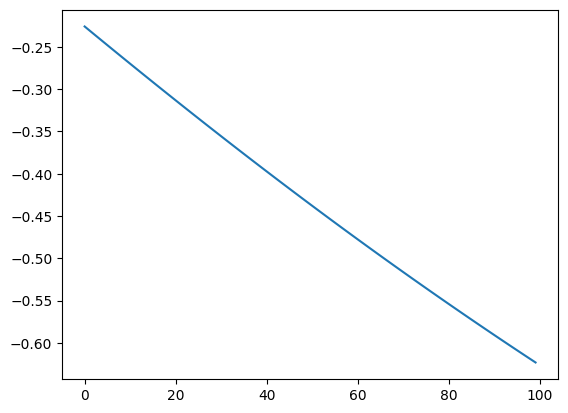

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.log(loss_list))

In [16]:
slope_b, intercept = np.polyfit(np.arange(0,100,1), np.log(loss_list), 1)
slope_b

-0.004017217146114877

In [17]:
k_b = -1/slope_b
k_b

248.92854023764136

### 2.d. Gradient Descent with Nesterov

In [18]:
class logistic_t:
    def __init__(self, w, b, lambda_1, rho, lr) :
        self.w = w
        self.b = b
        self.dw = np.zeros((1,784))
        self.db = np.zeros((1,1))
        self.lambda_1 = lambda_1
        self.u_w = w
        self.u_b = b
        self.rho = rho
        self.eta = lr

    def forward(self,x, y):
        hl = np.matmul(x, self.w.T) + self.b
        # cache h^l in forward because we will need it to compute
        # dw in backward
        self.x = x
        self.hl = hl
        self.y = y
        ell = np.mean(np.log(1 + np.exp(-y * hl))) + (self.lambda_1 / 2) * (np.sum(self.w**2) + self.b**2)
        # print(self.y.shape, self.hl.shape)
        ## for error we need tanh
        hl1 = (np.exp(hl) - np.exp(-hl)) / (np.exp(hl) + np.exp(-hl)) ## tanh to get categorical -1, 1 as output for error calculation
        output_cat = np.where(hl1>=0, 1, -1)
        error = (1/hl.shape[0]) * ((output_cat!=y).sum())
        return ell[0][0], error

    def backward(self):
        temp_w = self.w + self.rho * self.eta * self.u_w
        temp_b = self.b + self.rho * self.eta * self.u_b
        self.hu = np.matmul(self.x, temp_w.T) + temp_b
        error = -self.y / (1 + np.exp(self.y * self.hu))
        self.dw = (np.dot(error.T, self.x) / self.y.shape[0]) + (self.lambda_1 * temp_w)
        self.db = np.sum(error) / self.y.shape[0]
        self.u_w = self.rho * self.u_w - self.dw
        self.u_b = self.rho * self.u_b - self.db
        # self.dw = np.matmul((-y/(1+self.exp_hl)).T, self.x)
        # self.db = np.sum(1/(1+self.exp_hl))
        # notice that there is no need to cache dhl
        return

    def zero_grad(self):
        # useful to delete the stored backprop gradients of the
        # previous mini-batch before you start a new mini-batch
        self.dw, self.db = 0*self.dw, 0*self.db

In [19]:
# initialize all the layers
lambda_1 = 1e-4
L = [0.75, 0.85, 0.95]
final_loss_list = []
final_error_list = []
slope_list = []
t_list = [100,50]
for L_i in L:
    # train for at least 1000 iterations
    for t in t_list:
        # print(t)
        error_list = []
        loss_list = []
        rho = L_i/k_b
        lr = 1e-3
        l1 = logistic_t(copy.deepcopy(weights_init), copy.deepcopy(bias_init), lambda_1, rho, lr)
        net = [l1]
        for i in range(t):
            # 1. sample a mini-batch of size =32
            # each image in the mini - batch is chosen uniformly randomly from the
            # training dataset
            # index = np.random.choice(30000, 32)
            # x, y = X_train[index], y_train[index]

            # 2. zero gradient buffer
            for l in net:
                l.zero_grad()

            # 3. forward pass
            ell , error  = l1.forward(x, y)
            error_list += [error]
            loss_list += [ell]
            # print(np.max(l1.w), np.max(l1.b))
            # 4. backward pass
            dx = l1.backward()

            # 5. gather backprop gradients
            dw, db = l1.dw , l1.db

            # 6. print some quantities for logging
            # and debugging
            print(i,t, error, ell)
            # print(l1.w, l1.b)
            # print(dw.shape,db)
            # print(t, np.linalg.norm(dw/l1.w), np.linalg.norm(db/l1.b))

            # 7. one step of SGD
            l1.w = l1.w + lr * l1.u_w
            l1.b = l1.b + lr * l1.u_b
        # print(len(loss_list))
        final_loss_list.append(loss_list)
        final_error_list.append(error_list)
        slope, _ = np.polyfit(np.arange(0,t,1), np.log(loss_list), 1)
        slope_list.append(slope)
        print('Slope of ', L_i, ' is ', slope)

0 100 0.5323332017370707 0.7978531854746824
1 100 0.5323332017370707 0.762991717029663
2 100 0.5323332017370707 0.7301176102380466
3 100 0.5323332017370707 0.699263044889122
4 100 0.5323332017370707 0.670333725230676
5 100 0.532254243979471 0.6432283103804737
6 100 0.5308330043426767 0.6178415171142763
7 100 0.5234109751283064 0.5940666229883065
8 100 0.5019344650611922 0.5717976145422269
9 100 0.46103434662455584 0.5509309357163084
10 100 0.40465850769838135 0.5313668311271985
11 100 0.34433478089222264 0.5130103091402564
12 100 0.2871693643900513 0.49577176912657883
13 100 0.23703118831425188 0.4795673470560819
14 100 0.1966048164232136 0.4643190357638777
15 100 0.16170548756415318 0.44995463318839374
16 100 0.13335965258586657 0.43640756575027156
17 100 0.1117252270035531 0.4236166265094264
18 100 0.09427556257402289 0.4115256599937083
19 100 0.07998420844848006 0.4000832183787184
20 100 0.06798262929332807 0.3892422074056342
21 100 0.05858665613896565 0.3789595351959592
22 100 0.04

In [20]:
slope_list

[-0.016958227605169424,
 -0.025679089010583092,
 -0.01696055650068773,
 -0.025684622221268286,
 -0.016962886083846575,
 -0.025690157976130366]

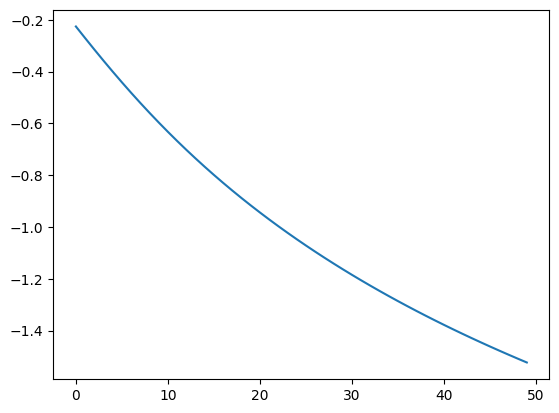

In [21]:
plt.plot(np.log(final_loss_list[-1]))

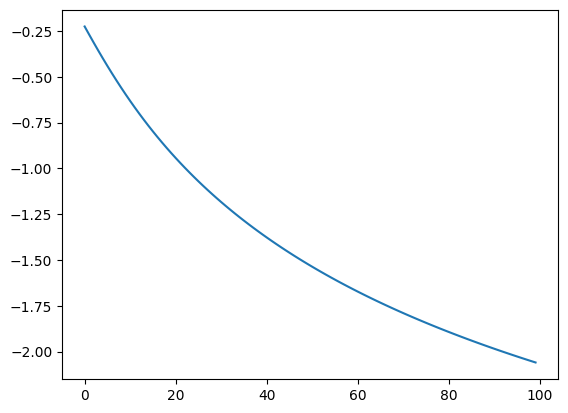

In [22]:
plt.plot(np.log(final_loss_list[-2]))

In [23]:
slope, intercept = np.polyfit(np.arange(0,50,1), np.log(final_loss_list[-1]), 1)
slope

-0.025690157976130366

In [24]:
slope, intercept = np.polyfit(np.arange(0,100,1), np.log(final_loss_list[-2]), 1)
slope

-0.016962886083846575

### 2.e

### SGD without nesterov

In [25]:
class logistic_t:
    def __init__(self, w, b, lambda_1) :

        self.w = w
        self.b = b
        self.dw = np.zeros((1,784))
        self.db = np.zeros((1,1))
        self.lambda_1 = lambda_1

    def forward(self,x, y):
        hl = np.matmul(x, self.w.T) + self.b
        # cache h^l in forward because we will need it to compute
        # dw in backward
        self.x = x
        self.hl = hl
        self.y = y
        ell = np.mean(np.log(1 + np.exp(-y * hl))) + (self.lambda_1 / 2) * (np.sum(self.w**2) + self.b**2)
        # print(self.y.shape, self.hl.shape)
        ## for error we need tanh
        hl1 = (np.exp(hl) - np.exp(-hl)) / (np.exp(hl) + np.exp(-hl)) ## tanh to get categorical -1, 1 as output for error calculation
        output_cat = np.where(hl1>=0, 1, -1)
        error = (1/hl.shape[0]) * ((output_cat!=y).sum())
        return ell[0][0], error

    def backward(self):
        error = -self.y / (1 + np.exp(self.y * self.hl))
        self.dw = (np.dot(error.T, self.x) / self.y.shape[0]) + (self.lambda_1 * self.w)
        self.db = np.sum(error) / self.y.shape[0]
        # self.dw = np.matmul((-y/(1+self.exp_hl)).T, self.x)
        # self.db = np.sum(1/(1+self.exp_hl))
        # notice that there is no need to cache dhl
        return

    def zero_grad(self):
        # useful to delete the stored backprop gradients of the
        # previous mini-batch before you start a new mini-batch
        self.dw, self.db = 0*self.dw, 0*self.db

In [26]:
# initialize all the layers
lambda_1 = 1e-4
l1 = logistic_t(copy.deepcopy(weights_init), copy.deepcopy(bias_init), lambda_1)
net = [l1]
lr = 1e-3

final_error_list = []
final_loss_list = []

# train for at least 1000 iterations
for t in range(100):
    # 1. sample a mini-batch of size =32
    # each image in the mini - batch is chosen uniformly randomly from the
    # training dataset
    index = np.random.choice(x.shape[0], 128)
    x_train, y_train = x[index], y[index]

    # 2. zero gradient buffer
    for l in net:
        l.zero_grad()

    # 3. forward pass
    ell , error  = l1.forward(x_train, y_train)
    final_error_list += [error]
    final_loss_list += [ell]
    # print(np.max(l1.w), np.max(l1.b))
    # 4. backward pass
    dx = l1.backward()

    # 5. gather backprop gradients
    dw, db = l1.dw , l1.db

    # 6. print some quantities for logging
    # and debugging
    print(t, error, ell)
    # print(t, error/150, ell/150)
    # final_loss_list += [ell/150]
    # final_error_list += [error/150]
    # print(l1.w, l1.b)
    # print(dw.shape,db)
    # print(t, np.linalg.norm(dw/l1.w), np.linalg.norm(db/l1.b))

    # 7. one step of SGD
    l1.w = l1.w - lr * dw
    l1.b = l1.b - lr * db

0 0.5078125 0.7826411604761799
1 0.515625 0.7644169711109047
2 0.5703125 0.8345507888120188
3 0.59375 0.8362048928353333
4 0.5625 0.8128714095407665
5 0.5859375 0.8336709131766833
6 0.5859375 0.836060971127163
7 0.46875 0.7124280763018389
8 0.4921875 0.728289178409
9 0.5078125 0.7447321972603299
10 0.46875 0.7033003148462901
11 0.5234375 0.7484397407626342
12 0.640625 0.859874694541136
13 0.625 0.8380126549728194
14 0.5078125 0.7161145667052814
15 0.5 0.7332108227391532
16 0.5078125 0.731821448480233
17 0.5 0.7075975214458432
18 0.5234375 0.7250170901446051
19 0.4921875 0.7007277215309831
20 0.4921875 0.7124846780029523
21 0.53125 0.7286573269093506
22 0.453125 0.6363232062603751
23 0.6171875 0.7859154083584214
24 0.5859375 0.7722293527331024
25 0.515625 0.7089632717192456
26 0.578125 0.7497428945393089
27 0.46875 0.6574530149524446
28 0.4921875 0.6678100612629485
29 0.5703125 0.733989339389015
30 0.4921875 0.6726461346105188
31 0.5859375 0.7567217003959676
32 0.5234375 0.6828747828547

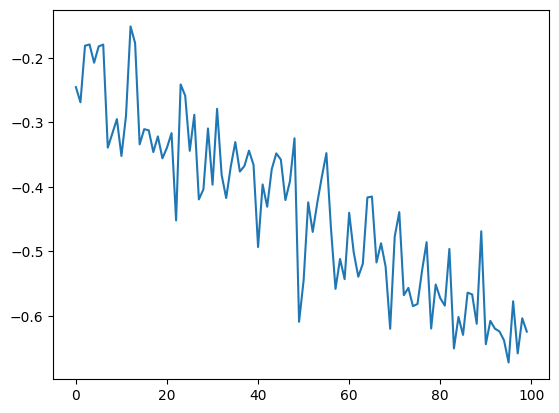

In [27]:
plt.plot(np.log(final_loss_list))

In [28]:
slope, intercept = np.polyfit(np.arange(0,100,1), np.log(final_loss_list), 1)
slope

-0.004197421556830829

In [29]:
k_b_sgd = -1/slope
k_b_sgd

238.24149813416125

### SGD with Nesterov

In [30]:
class logistic_t:
    def __init__(self, w, b, lambda_1, rho, lr) :
        self.w = w
        self.b = b
        self.dw = np.zeros((1,784))
        self.db = np.zeros((1,1))
        self.lambda_1 = lambda_1
        self.u_w = w
        self.u_b = b
        self.rho = rho
        self.eta = lr

    def forward(self,x, y):
        hl = np.matmul(x, self.w.T) + self.b
        # cache h^l in forward because we will need it to compute
        # dw in backward
        self.x = x
        self.hl = hl
        self.y = y
        ell = np.mean(np.log(1 + np.exp(-y * hl))) + (self.lambda_1 / 2) * (np.sum(self.w**2) + self.b**2)
        # print(self.y.shape, self.hl.shape)
        ## for error we need tanh
        hl1 = (np.exp(hl) - np.exp(-hl)) / (np.exp(hl) + np.exp(-hl)) ## tanh to get categorical -1, 1 as output for error calculation
        output_cat = np.where(hl1>=0, 1, -1)
        error = (1/hl.shape[0]) * ((output_cat!=y).sum())
        return ell[0][0], error

    def backward(self):
        temp_w = self.w + self.rho * self.eta * self.u_w
        temp_b = self.b + self.rho * self.eta * self.u_b
        self.hu = np.matmul(self.x, temp_w.T) + temp_b
        error = -self.y / (1 + np.exp(self.y * self.hu))
        self.dw = (np.dot(error.T, self.x) / self.y.shape[0]) + (self.lambda_1 * temp_w)
        self.db = np.sum(error) / self.y.shape[0]
        self.u_w = self.rho * self.u_w - self.dw
        self.u_b = self.rho * self.u_b - self.db
        # self.dw = np.matmul((-y/(1+self.exp_hl)).T, self.x)
        # self.db = np.sum(1/(1+self.exp_hl))
        # notice that there is no need to cache dhl
        return

    def zero_grad(self):
        # useful to delete the stored backprop gradients of the
        # previous mini-batch before you start a new mini-batch
        self.dw, self.db = 0*self.dw, 0*self.db

In [31]:
# initialize all the layers
lambda_1 = 1e-4
L = [0.75, 0.85, 0.95]
final_loss_list = []
final_error_list = []
slope_list = []
t_list = [100,50]
for L_i in L:
    # train for at least 1000 iterations
    for t in t_list:
        # print(t)
        error_list = []
        loss_list = []
        rho = L_i/k_b_sgd
        lr = 1e-3
        l1 = logistic_t(copy.deepcopy(weights_init), copy.deepcopy(bias_init), lambda_1, rho, lr)
        net = [l1]
        for i in range(t):
            # 1. sample a mini-batch of size =32
            # each image in the mini - batch is chosen uniformly randomly from the
            # training dataset
            # index = np.random.choice(30000, 32)
            # x, y = X_train[index], y_train[index]
            index = np.random.choice(x.shape[0], 128)
            x_train, y_train = x[index], y[index]

            # 2. zero gradient buffer
            for l in net:
                l.zero_grad()

            # 3. forward pass
            ell , error  = l1.forward(x_train, y_train)
            error_list += [error]
            loss_list += [ell]
            # print(np.max(l1.w), np.max(l1.b))
            # 4. backward pass
            dx = l1.backward()

            # 5. gather backprop gradients
            dw, db = l1.dw , l1.db

            # 6. print some quantities for logging
            # and debugging
            print(i,t, error, ell)
            # print(l1.w, l1.b)
            # print(dw.shape,db)
            # print(t, np.linalg.norm(dw/l1.w), np.linalg.norm(db/l1.b))

            # 7. one step of SGD
            l1.w = l1.w + lr * l1.u_w
            l1.b = l1.b + lr * l1.u_b
        # print(len(loss_list))
        final_loss_list.append(loss_list)
        final_error_list.append(error_list)
        slope, _ = np.polyfit(np.arange(0,t,1), np.log(loss_list), 1)
        slope_list.append(slope)
        print('Slope of ', L_i, ' is ', slope)

0 100 0.4765625 0.7519041915909073
1 100 0.5078125 0.7464493579925305
2 100 0.453125 0.6533558842830627
3 100 0.515625 0.7044179991670373
4 100 0.5078125 0.6554438583119405
5 100 0.546875 0.6704280489391551
6 100 0.546875 0.6367821681701079
7 100 0.4921875 0.5851752744373789
8 100 0.5234375 0.5856017592081316
9 100 0.5078125 0.5507314563437171
10 100 0.4375 0.5361895047728913
11 100 0.4296875 0.5203860152110923
12 100 0.296875 0.46669409189729477
13 100 0.2890625 0.4832567908734511
14 100 0.234375 0.4776558133150809
15 100 0.1875 0.4473637418816033
16 100 0.171875 0.46168314637148394
17 100 0.1171875 0.4116673315354366
18 100 0.0859375 0.4158738646395364
19 100 0.078125 0.4302876194594206
20 100 0.0546875 0.3827817331471454
21 100 0.03125 0.3613148929755341
22 100 0.09375 0.370982552919159
23 100 0.0546875 0.38943137647610687
24 100 0.0390625 0.35257900881628407
25 100 0.046875 0.3271274764621433
26 100 0.0234375 0.331759312253548
27 100 0.0390625 0.3475981269302664
28 100 0.046875 0.3

In [32]:
slope_list

[-0.016848592994713054,
 -0.025928488591694915,
 -0.016926321300999417,
 -0.025030185697337407,
 -0.01710471997114275,
 -0.02485306778363618]

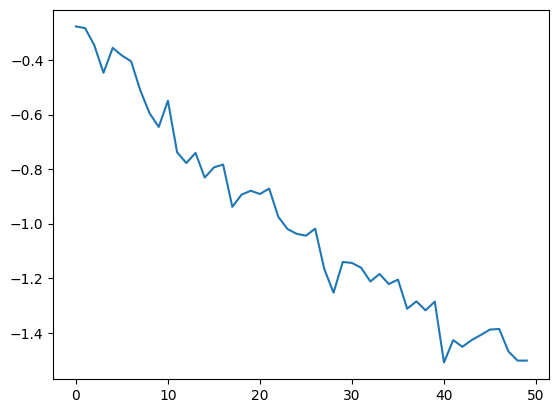

In [33]:
plt.plot(np.log(final_loss_list[-1]))

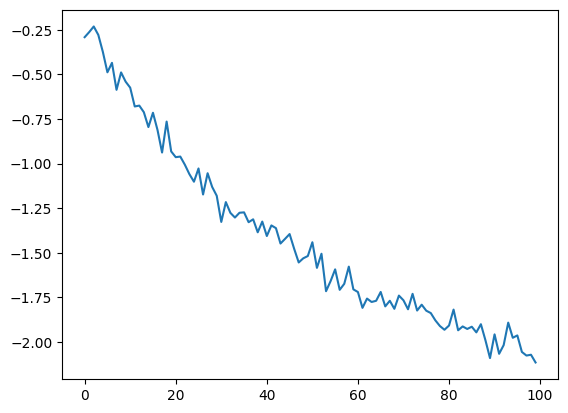

In [34]:
plt.plot(np.log(final_loss_list[-2]))

In [35]:
slope, intercept = np.polyfit(np.arange(0,50,1), np.log(final_loss_list[-1]), 1)
slope

-0.02485306778363618

In [36]:
slope, intercept = np.polyfit(np.arange(0,100,1), np.log(final_loss_list[-2]), 1)
slope

-0.01710471997114275